In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

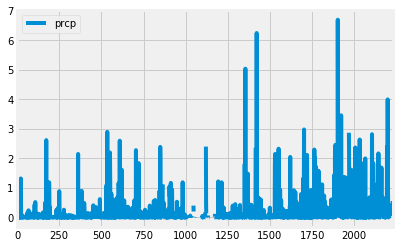

In [154]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last

# Perform a query to retrieve the data and precipitation scores

prcp=session.query(Measurement.prcp, Measurement.date).filter(Measurement.date<='2017-08-23').\
    filter(Measurement.date>='2016-08-23').all()
prcp

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp)

prcp_df

# Sort the dataframe by date
#prcp_df.sortby('date')
prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot()


In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [71]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement.station).group_by(Measurement.station).count()

9

In [102]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [167]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()




[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'temperature observation')

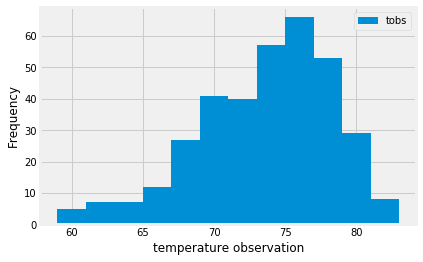

In [178]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

tobs=session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').\
    filter(Measurement.date<='2017-08-23').\
    filter(Measurement.date>=query_date).all()
#tobs

tobs_df=pd.DataFrame(tobs,columns=["tobs"])
tobs_df.plot.hist(bins=12)

plt.xlabel("temperature observation")

In [180]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-03-28', '2018-03-28'))

[(58.0, 76.39677047289504, 87.0)]


In [181]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-03-21', '2017-03-28'))

[(69.0, 74.23404255319149, 80.0)]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


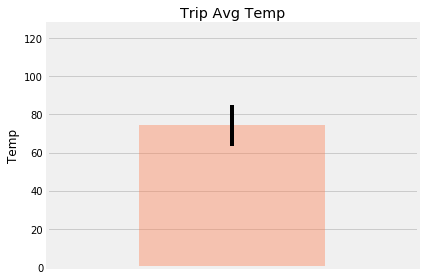

In [201]:
# Plot the results from your previous query as a bar chart.
fig,ax=plt.subplots()

temps_min,temps_avg, temps_max =calc_temps('2017-03-21', '2017-03-28')[0]

ax.bar(1, temps_avg, yerr=temps_max-temps_min, color="coral", alpha=.4)
ax.set(xticks= range(1), title= "Trip Avg Temp", ylabel="Temp")
ax.margins(.5,.5)
fig.tight_layout()
fig.show()

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [205]:
# Calculate the total amount of rainfall per weather station for your trip dates using the 
#previous year's matching dates.

vacay=session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
    func.sum(Measurement.prcp)).filter(Measurement.station== Station.station).\
    filter(Measurement.date<='2017-03-28').\
    filter(Measurement.date>='2017-03-21').group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

for i in vacay:
    print (i)

# Sort this in descending order by precipitation amount and list the station, name, 
#latitude, longitude, and elevation



('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.3599999999999999)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.1500000000000001)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.76)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.52)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.15)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
